In [1]:
# sefa

In [2]:
import sys
sys.path.append('/workspace/stylegan3encoder/')
import copy
import os
import os.path as osp
import re
from tqdm import tqdm
from typing import List, Optional, Tuple, Union

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F

import legacy
from face_alignment import image_align
from landmarks_detector import LandmarksDetector

In [3]:
# set device
device = torch.device('cuda:3')
# set model paths
ckptbasedir = '/workspace/stylegan3encoder/ckpts/'
network_pkl = osp.join(ckptbasedir, 'stylegan3-t-ffhq-1024x1024.pkl')
landmark_ckpt_path = osp.join(ckptbasedir, 'dlib', 'shape_predictor_68_face_landmarks.dat')

In [4]:
# load models
landmark_detector = LandmarksDetector(landmark_ckpt_path)
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

In [5]:
from sefa import factorize_weight

In [6]:
distances = np.linspace(-30,30,5)
layers,boundaries, values = factorize_weight(G)

In [11]:
seeds = 10
imgs = []
result = None
attribute_id = 2
boundary = boundaries[attribute_id:attribute_id+1]

for seed in range(seeds):
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
    label = torch.zeros([1,G.c_dim],device=device)
    w = G.mapping(z,label, truncation_psi=0.7)
    codes = w.detach().cpu().numpy()

    for dist in distances:
        temp_code = copy.deepcopy(codes)
        temp_code[:,[1,2],:] += boundary * dist
        img = G.synthesis(torch.from_numpy(temp_code).to(device), noise_mode='const', force_fp32=True)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        imgs.append(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((128,128))) #.save(f'{outdir}/{fn}.png')


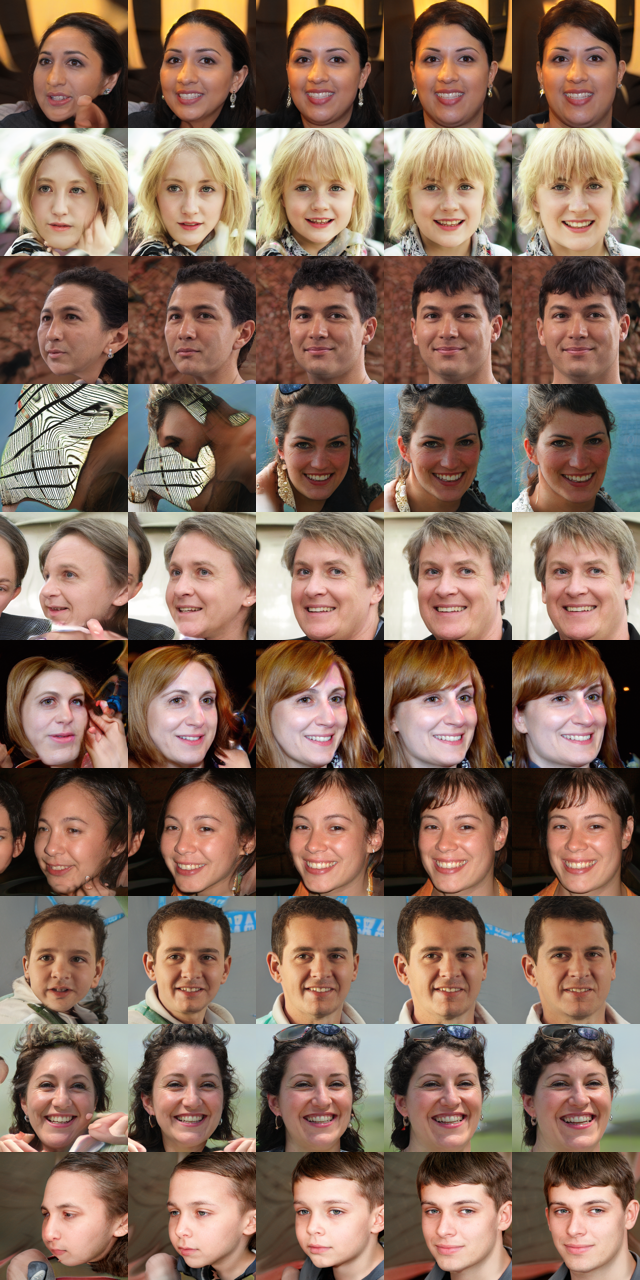

In [12]:
gw, gh = (5, seeds)
H, W = (128,128)
result = np.stack(imgs)
result = result.reshape(gh, gw, H, W, 3)
result = result.transpose(0,2,1,3,4)
result = result.reshape(gh * H, gw * W, 3)
display(PIL.Image.fromarray(result, 'RGB'))